In [2]:
from app import db
from app.models import *
from app.build_models import get_decision_text, get_vote_history, vote_map

import pandas as pd
import numpy as np
import re
import json
from scipy.sparse import csr_matrix
import pickle

from sklearn.decomposition import TruncatedSVD, PCA
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer
from sklearn import metrics

from datetime import datetime
import nltk
from nltk.stem.snowball import SnowballStemmer
from textblob import TextBlob
stemmer = SnowballStemmer('english')
stopwords = nltk.corpus.stopwords

from PIL import Image
from PIL.ImageOps import invert
from wordcloud import WordCloud, STOPWORDS

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import mpld3
sns.set_palette('viridis')
%matplotlib notebook

from palettable.colorbrewer.sequential import Greens_9

def color_func(word, font_size, position, orientation, random_state=None, **kwargs):
    return tuple(Greens_9.colors[np.random.randint(4,9)])

DB_URI : sqlite://///Users/mayen/Programming/WillItPass/tmp/congress.db
##################################################
Building member models
RQ ID : c61d2b8c-ec2f-4d39-bc32-298ad887ae6c
Build job set in queue
##################################################


/Users/mayen/anaconda/envs/python35/lib/python3.5/site-packages/IPython/core/formatters.py:98: DeprecationWarning: DisplayFormatter._formatters_default is deprecated: use @default decorator instead.
  def _formatters_default(self):
/Users/mayen/anaconda/envs/python35/lib/python3.5/site-packages/IPython/core/formatters.py:677: DeprecationWarning: PlainTextFormatter._deferred_printers_default is deprecated: use @default decorator instead.
  def _deferred_printers_default(self):
/Users/mayen/anaconda/envs/python35/lib/python3.5/site-packages/IPython/core/formatters.py:669: DeprecationWarning: PlainTextFormatter._singleton_printers_default is deprecated: use @default decorator instead.
  def _singleton_printers_default(self):
/Users/mayen/anaconda/envs/python35/lib/python3.5/site-packages/IPython/core/formatters.py:672: DeprecationWarning: PlainTextFormatter._type_printers_default is deprecated: use @default decorator instead.
  def _type_printers_default(self):
/Users/mayen/anaconda/envs/

In [3]:
members = db.session.query(Member).all()

In [4]:
mem = members[190]
memid = mem.id
mem.display_name

/Users/mayen/anaconda/envs/python35/lib/python3.5/site-packages/IPython/core/formatters.py:669: DeprecationWarning: PlainTextFormatter._singleton_printers_default is deprecated: use @default decorator instead.
  def _singleton_printers_default(self):


'Warren (D-MA)'

In [5]:
vectorizer = pickle.load(open(mem.vectorizer_path,'rb'))
nn_model = pickle.load(open(mem.nn_model_path,'rb'))

In [6]:
text = get_decision_text(memid)
df = pd.DataFrame(text,columns=['title','question','subject'])
df['vote'] = get_vote_history(memid)
df['body'] = df['title'].str.cat(df['question'],sep=' ').str.cat(df['subject'],sep=' ')
df['body'] = df['body'].apply(lambda x: re.sub("\d+", "", x))
df['result'] = df['vote'].apply(vote_map)

In [7]:
yay = df[df['result']==1]
yay_matrix = vectorizer.fit_transform(yay['body'])
kmeans = KMeans(6)
kmeans.fit_transform(yay_matrix)
yay['cluster'] = kmeans.labels_.tolist()

/Users/mayen/anaconda/envs/python35/lib/python3.5/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [8]:
yay['cluster'].value_counts()

5    262
2    211
1    139
4    123
3     48
0     41
Name: cluster, dtype: int64

In [28]:
def get_word_freq_from_centroid(centroid,features,n=100):
    """Given the centroid and features return the
    top n words with their tfidf"""
    ordered_centroid = centroid.argsort()[::-1]
    word_freq = {}
    for ind in ordered_centroid[:n]:
        word = features[ind]
        word_freq[word] = centroid[ind]
    return word_freq

def merge_dicts(list_of_dicts):
    c = {}
    for d in list_of_dicts:
        c.update(d)
    return c

In [11]:
features = vectorizer.get_feature_names()
centroids = kmeans.cluster_centers_
topic_freq = [get_word_freq_from_centroid(centroid, features, 10)\
                      for centroid in kmeans.cluster_centers_]

In [29]:
word_freqs = merge_dicts(topic_freq)
word_freqs

{'act': 0.12136858133344187,
 'act amendment': 0.071515366288297855,
 'act amendment amdt': 0.071515366288297855,
 'amdt': 0.16050843024037709,
 'amdt amdt': 0.056507000154377339,
 'amendment': 0.061760599689743609,
 'amendment amdt': 0.065640571117062604,
 'amendment amdt amdt': 0.058358491427897244,
 'applicable': 0.1291520848073133,
 'applicable budgetary': 0.13014121867817641,
 'applicable budgetary discipline': 0.13014121867817641,
 'appropriations': 0.044000737346534327,
 'budgetary discipline': 0.13014121867817641,
 'child': 0.049100996070761113,
 'child achieves act': 0.047472752264106841,
 'circuit': 0.063770974759329788,
 'cloture': 0.018860724121662672,
 'cloture motion': 0.059053069973166249,
 'cloture motion proceed': 0.050516667388247498,
 'confirmation': 0.01631797208282745,
 'discipline': 0.13014121867817641,
 'district': 0.13177198739371346,
 'district judge': 0.079266746001412397,
 'file': 0.27321152152721834,
 'file amendment': 0.13282716370029096,
 'file amendment a

In [52]:
print("Top terms per cluster:")
print()
#sort cluster centers by proximity to centroid
terms = vectorizer.get_feature_names()
num_clusters = len(yay['cluster'].unique())
centroids = kmeans.cluster_centers_
order_centroids = centroids.argsort()[:, ::-1] 
centroids.sort()

for i in range(num_clusters):
    print("Cluster %d words:" % i, end='')
    a = []
    for ind in order_centroids[i, :100]: #replace 6 with n words per cluster
        a.append({terms[ind]:centroids[i,ind]})
        print(' %s' % terms[ind].split(' '))
    print() 
    print() 
    
print()
print()

Top terms per cluster:

Cluster 0 words: ['zika', 'funding', 'nelson']
 ['yoshiho', 'hirozawa', 'new']
 ['yoshiho', 'hirozawa']
 ['zika', 'funding']
 ['zika']
 ['yoshiho']
 ['york', 'vice', 'president']
 ['york', 'vice', 'chairman']
 ['york', 'vice']
 ['york', 'united', 'states']
 ['york', 'united']
 ['york', 'secretary', 'treasury']
 ['york', 'secretary', 'state']
 ['york', 'secretary', 'education']
 ['york', 'secretary']
 ['york', 'president', 'export']
 ['york', 'president']
 ['york', 'nomination', 'lashann']
 ['york', 'nomination']
 ['york', 'motion', 'invoke']
 ['york', 'motion']
 ['york', 'member', 'national']
 ['york', 'member', 'board']
 ['york', 'member']
 ['york', 'general', 'counsel']
 ['york', 'district']
 ['york', 'district', 'judge']
 ['york', 'general']
 ['york', 'director']
 ['york', 'deputy', 'secretary']
 ['york', 'deputy']
 ['york', 'director', 'office']
 ['york', 'confirmation', 'valerie']
 ['york', 'confirmation', 'nelson']
 ['york', 'confirmation', 'lawrence']
 ['

In [59]:
a = {list(entry.keys())[0]:list(entry.values())[0] for entry in a}
a

{'years confirmation christopher': 0.0069075245412006381,
 'years confirmation david': 0.0069739584333076031,
 'years confirmation elaine': 0.0069826600429628988,
 'years confirmation james': 0.0069963143696965104,
 'years confirmation katherine': 0.0070462255854803852,
 'years confirmation matthew': 0.0072069399778052047,
 'years confirmation melvin': 0.0072069399778052047,
 'years confirmation richard': 0.0072110834640358983,
 'years confirmation stanley': 0.0073319928222040998,
 'years confirmation vivek': 0.007426254211620905,
 'years expiring': 0.0075470681403939114,
 'years expiring august': 0.0077485046152510765,
 'years expiring december': 0.0077485046152510765,
 'years expiring june': 0.0077931757735323313,
 'years february': 0.0079114469349342992,
 'years february confirmation': 0.008092351644306179,
 'years february motion': 0.008092351644306179,
 'years motion': 0.00827801265139037,
 'years motion brown': 0.00827801265139037,
 'years motion burr': 0.00827801265139037,
 'yea

In [11]:
from app.member_topics import member_vote_topics
from app.cloud import make_word_cloud

In [12]:
topic = member_vote_topics(memid)
yay = topic['Yea']
cloud,mask = make_word_cloud(yay)

/Users/mayen/Programming/WillItPass/app/member_topics.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sub['cluster'] = kmeans.labels_.tolist()


<IPython.core.display.Javascript object>


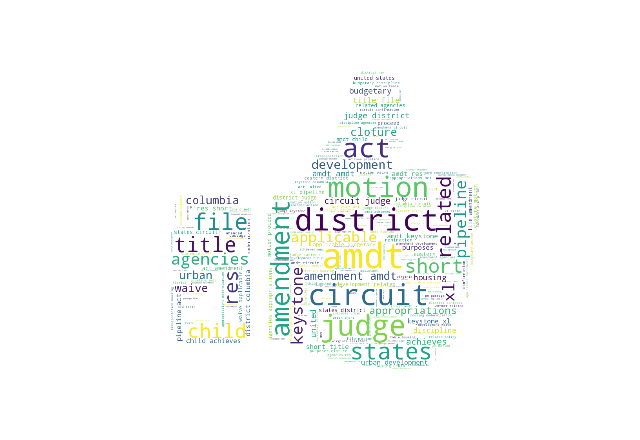

(-0.5, 899.5, 899.5, -0.5)

In [13]:
plt.imshow(cloud)
plt.axis('off')

<IPython.core.display.Javascript object>


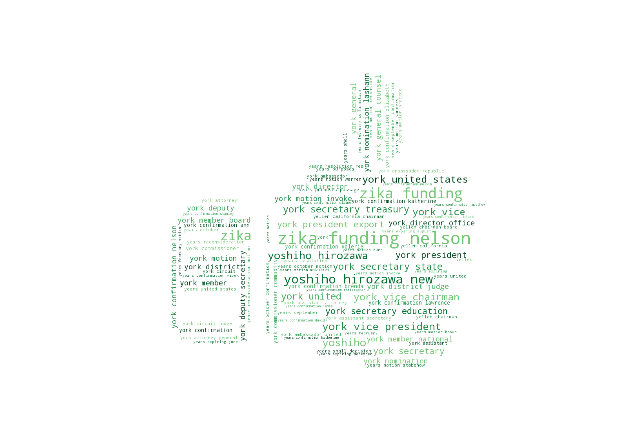

In [61]:
thumb = Image.open('app/static/img/thumbs-up.png')
mask = Image.new("RGB", thumb.size, (255,255,255))
mask.paste(thumb,thumb)
#mask = invert(mask)
mask = np.array(mask)

text = ' '.join(yay)
wc = WordCloud(background_color='white',
               max_words=100,
               mask=mask,
               stopwords=STOPWORDS,
              ).generate_from_frequencies(a)
wc.recolor(color_func=color_func, random_state=3)
plt.imshow(wc)
plt.axis('off')
plt.show()

In [17]:
plt.imshow(mask)
plt.show()

In [19]:
np.min(mask)

0